# Ethan's Modeling

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

## Get the Data

## Cleaning The Data
Most of the cleaning was done outside of this file. The cleaned data is in the `men_lead_no_drop.csv` file.

In [20]:
def impute(df):
    countries = df.country.unique()
    #dataset averages
    global_h = np.mean(df.height)
    global_w = np.mean(df.weight)
    global_a = np.mean(df.age)

    heights = []
    weights = []
    ages = []
    #steps through each country
    for co in countries:
        group = df[df['country'] == co]
        # counting datapoints within country
        count_h = np.count_nonzero(~np.isnan(group.height))
        count_w = np.count_nonzero(~np.isnan(group.weight))
        count_a = np.count_nonzero(~np.isnan(group.age))
        # sets thresholds between accepting the countries average or using dataset average to fill in NaN's
        if count_h >= 5:
            avg_h = np.mean(group.height)
        else:
            avg_h = global_h
        if count_w >= 5:
            avg_w = np.mean(group.weight)
        else:
            avg_w = global_w
        if count_a >= 10:
            avg_a = np.mean(group.weight)
        else:
            avg_a = global_a
        # steps through each person creating lists to replace current columns in dataframe
        for i in range(len(group)):
            if np.isnan(group.iloc[i].height):
                heights.append(avg_h)
            else:
                heights.append(group.iloc[i].height)
            if np.isnan(group.iloc[i].weight):
                weights.append(avg_w)
            else:
                weights.append(group.iloc[i].weight)
            if np.isnan(group.iloc[i].age):
                ages.append(avg_a)
            else:
                ages.append(group.iloc[i].age)
    #replacing columns of dataframe 
    imputed = df.copy()
    imputed['height'] = heights
    imputed['weight'] = weights
    imputed['age'] = ages    
    return imputed.fillna(0)

In [21]:
df = pd.read_csv('../data/men_lead_no_drop.csv')
df = impute(df)
df = df.drop(['id', 'last_name', 'first_name', 'points', 'rank'], axis=1)
df = pd.get_dummies(df)

test = df[df['year'] >= 2019]
X_test = test.drop(['avg_points'], axis=1)
y_test = test['avg_points']

train = df[df['year'] <= 2018]
X_train = train.drop(['avg_points'], axis=1)
y_train = train['avg_points']

df

,year,height,weight,age,career_len,event_count,avg_points,t-1,t-2,t-3,...,country_RUS,country_SGP,country_SLO,country_SUI,country_SVK,country_SWE,country_TPE,country_UKR,country_USA,country_VEN
0,2019,185.000000,67.000000,26.000000,10,3,100.000000,55.000000,80.000,51.000000,...,0,0,0,0,0,0,0,0,0,0
1,2019,179.047619,62.952381,29.000000,1,6,42.666667,43.000000,0.000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,2019,179.047619,62.952381,20.000000,16,6,34.333333,25.666667,63.500,55.800000,...,0,0,0,0,0,0,0,0,0,0
3,2019,179.047619,62.952381,19.000000,3,5,39.000000,12.000000,6.500,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,2019,185.000000,67.000000,25.000000,9,6,31.666667,66.571429,51.625,50.857143,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,1991,176.500000,59.000000,23.417059,0,1,3.000000,0.000000,0.000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2012,1991,174.134465,60.912929,-3.000000,0,1,2.000000,0.000000,0.000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2013,1991,174.134465,60.912929,-4.000000,0,3,0.666667,0.000000,0.000,0.000000,...,0,0,0,0,0,0,0,0,1,0
2014,1991,166.000000,55.000000,21.000000,0,1,1.000000,0.000000,0.000,0.000000,...,0,0,0,0,0,0,0,0,0,0


## Regression Models
These perform a number of regression models on the data with the training data taken from before 2019 and then predicting the 2019 numbers. The number we're using is the `avg_score` that year. And the way we look at how well the model predicted is using the `mean_squared_error` scoring function.

### Naive Baseline Model

MSE Value: 303.25793883473784


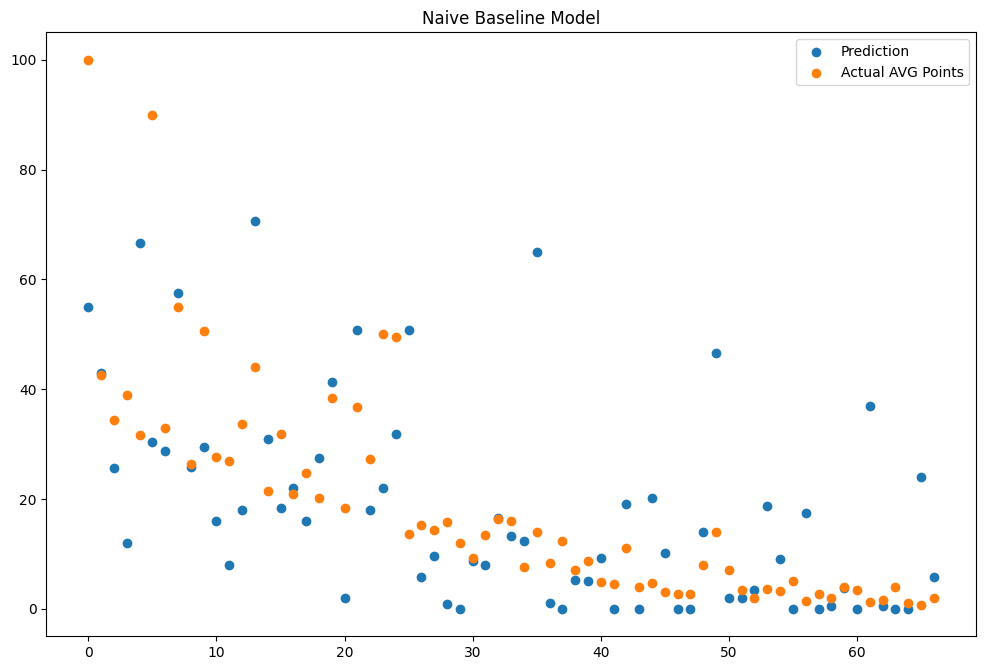

In [7]:
pred = X_test['t-1']
print("MSE Value:", mean_squared_error(pred, y_test))

plt.scatter(range(len(pred)), pred, label='Prediction')
plt.scatter(range(len(pred)), y_test, label='Actual AVG Points')
plt.title('Naive Baseline Model')
plt.legend()
plt.show()

### Boilerplate code for following Models
Testing the modesl below follows a lot of the same patterns, so let's just implement it in a simple function

In [9]:
def run_regression_model(model, param_grid, model_name):
    grid = GridSearchCV(model, param_grid, n_jobs=-1, scoring='neg_mean_squared_error').fit(X_train, y_train)
    pred = grid.predict(X_test)
    print("MSE Value:", mean_squared_error(pred, y_test))
    print("Best Params:", grid.best_params_)

    plt.scatter(range(len(pred)), pred, label='Prediction')
    plt.scatter(range(len(pred)), y_test, label='Actual AVG Points')
    plt.title(f'{model_name} - GridSearchCV')
    plt.legend()
    plt.show()

### Linear Regression

MSE Value: 257.4328596082272
Best Params: {'fit_intercept': True, 'normalize': False}


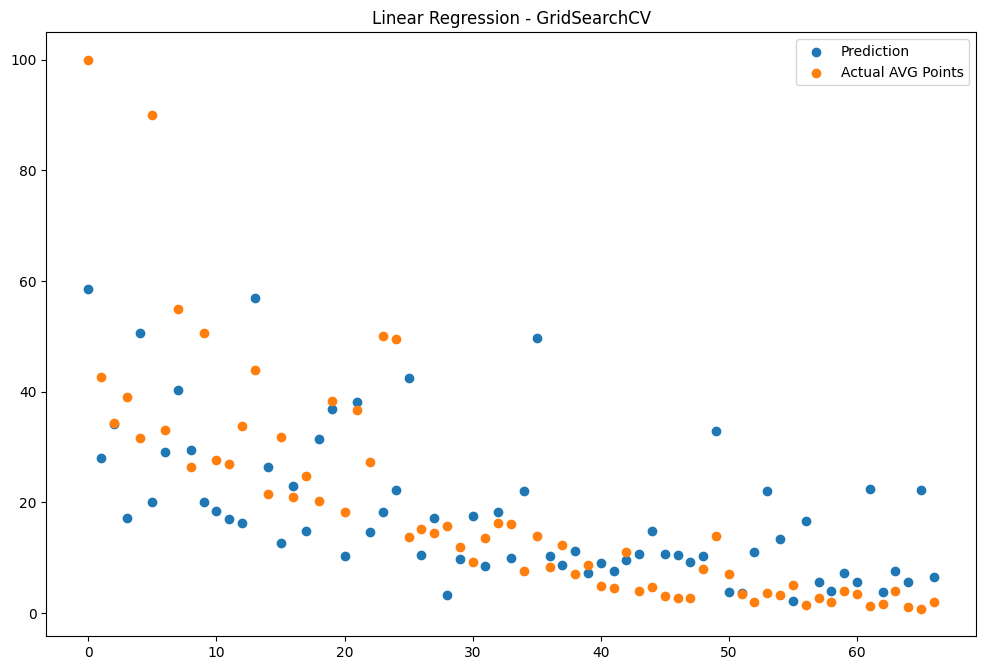

In [10]:
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

model = LinearRegression(n_jobs=-1)
run_regression_model(model, param_grid, 'Linear Regression')

### Lasso

MSE Value: 268.654437756919
Best Params: {'alpha': 1000.0, 'fit_intercept': True, 'normalize': False}


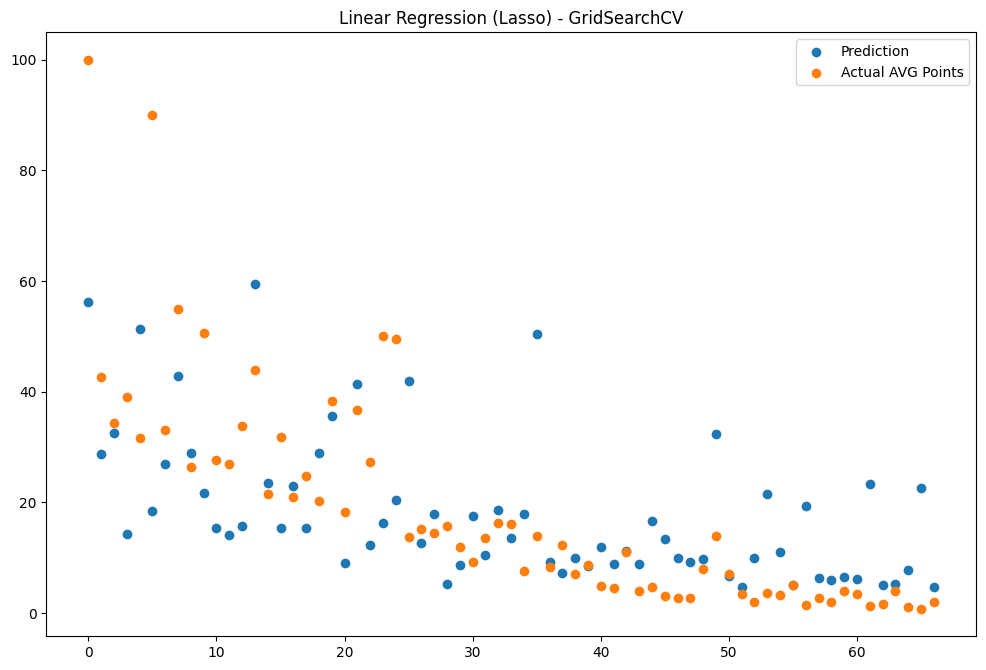

In [19]:
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

model = Lasso()
run_regression_model(model, param_grid, 'Linear Regression (Lasso)')

### Ridge

MSE Value: 263.9942373535829
Best Params: {'alpha': 0.1, 'fit_intercept': True, 'normalize': False}


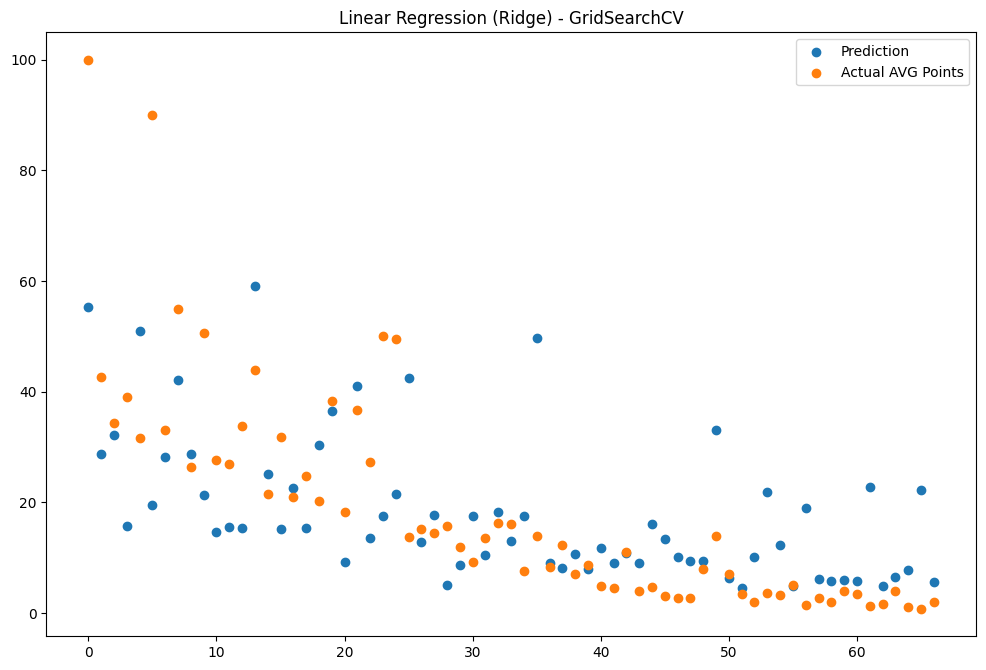

In [20]:
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4],
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

model = Ridge(max_iter=100000)
run_regression_model(model, param_grid, 'Linear Regression (Ridge)')

### Elastic Net

MSE Value: 266.48813737629916
Best Params: {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.001, 'normalize': False}


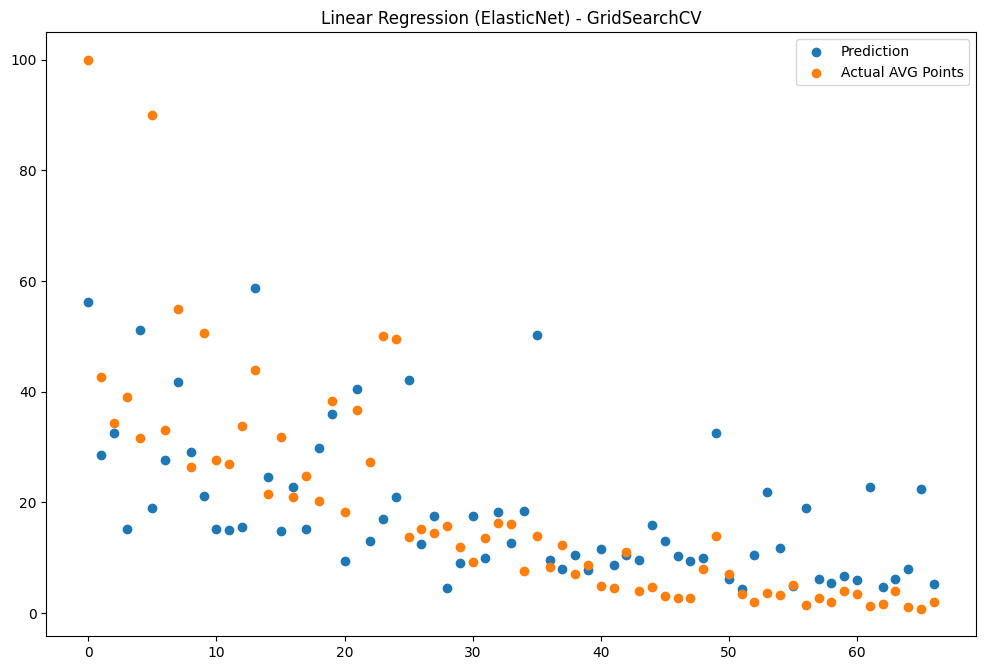

In [21]:
param_grid = {
    'alpha': [1e-3, 1e-1, 1e0, 1e2, 1e4],
    'l1_ratio': [1e-3, 1e-1, 1e0, 1e2, 1e4],
    'fit_intercept': [True, False],
    'normalize': [True, False]
}

model = ElasticNet(max_iter=100000)
run_regression_model(model, param_grid, 'Linear Regression (Elastic Net)')

### Decision Tree Regressor

MSE Value: 354.20020884697425
Best Params: {'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}


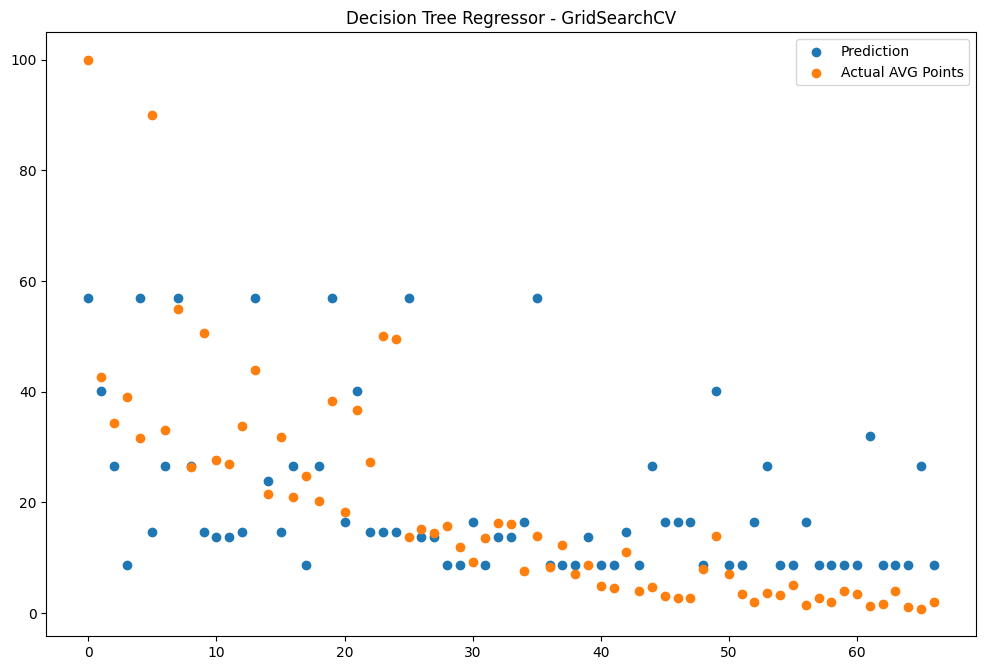

In [43]:
param_grid = {
    'max_depth': [1, 2, 5, 10, None],
    'max_leaf_nodes': [2, 5, 10, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10]
}

model = DecisionTreeRegressor()
run_regression_model(model, param_grid, 'Decision Tree Regressor')

### Random Forest Regressor

MSE Value: 320.8567521025479
Best Params: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 200}


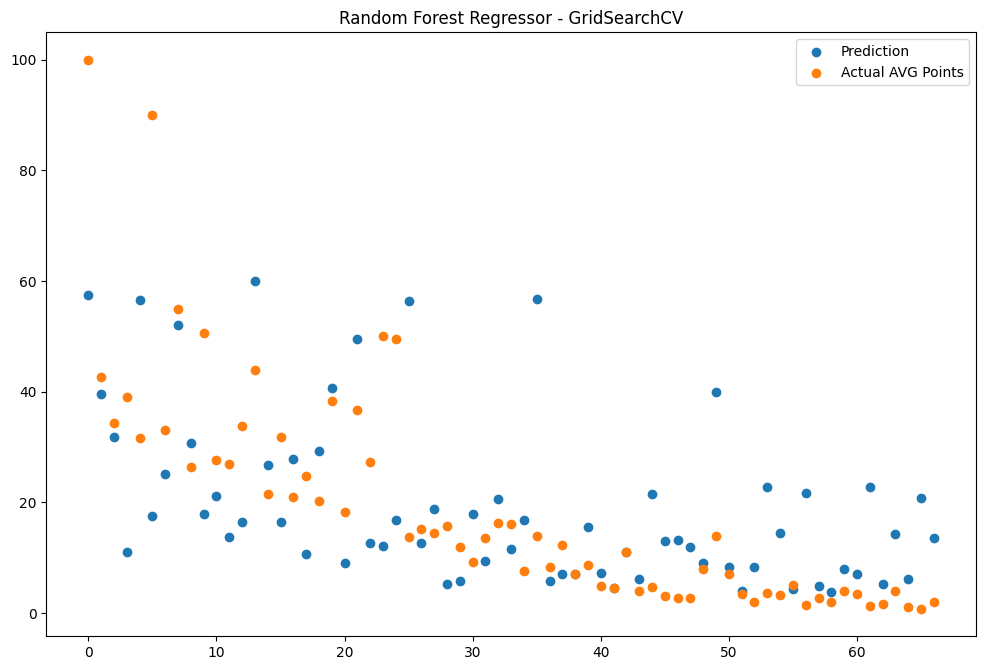

In [46]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [1, 2, 5, 10, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt']
}

model = RandomForestRegressor()
run_regression_model(model, param_grid, 'Random Forest Regressor')

### Gradient Boosted Regressor

MSE Value: 288.1305008621681
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 50}


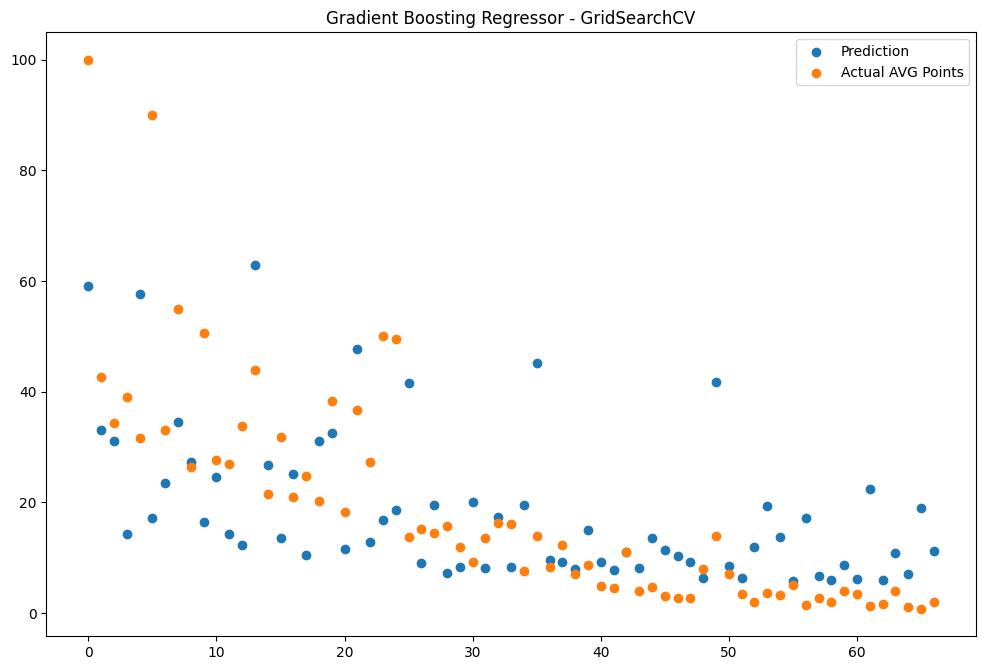

In [47]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 5, 10, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt']
}

model = GradientBoostingRegressor()
run_regression_model(model, param_grid, 'Gradient Boosting Regressor')

## Classification Methods

In [27]:
df = pd.read_csv('../data/men_lead_no_drop.csv')
df = impute(df)
df = df.drop(['id', 'last_name', 'first_name', 'points', 'rank'], axis=1)

le = LabelEncoder()
le.fit(df.country)
test = df[df['year'] >= 2019]
X_test = test.drop(['country'], axis=1).to_numpy()
y_test = le.transform(test['country'])

train = df[df['year'] <= 2018]
X_train = train.drop(['country'], axis=1).to_numpy()
y_train = le.transform(train['country'])

### Decision Tree Classifier

In [31]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 6, None],
    'max_leaf_nodes': [2, 3, 4, 5, 6, 10],
    'min_samples_leaf': [1, 2, 3, 5, 10]
}

model = DecisionTreeClassifier()
grid = GridSearchCV(model, param_grid, n_jobs=-1, scoring='accuracy').fit(X_train, y_train)
pred = grid.predict(X_test)
print("Accuracy Score:", accuracy_score(pred, y_test))
print("Best Params:", grid.best_params_)

# plt.scatter(range(len(pred)), pred, label='Prediction')
# plt.scatter(range(len(pred)), y_test, label='Actual AVG Points')
# plt.title('Decision Tree Classifier - GridSearchCV')
# plt.legend()
# plt.show()

/home/ebrouwerdev/.virtualenvs/ACME/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Accuracy Score: 0.05970149253731343
Best Params: {'criterion': 'entropy', 'max_depth': 1, 'max_leaf_nodes': 2, 'min_samples_leaf': 1}
